In [ ]:
# Run this cell once in your Python notebook to enable R code blocks
%load_ext rpy2.ipython


In [ ]:
%%R
install.packages("recommenderlab", repos='http://cran.us.r-project.org')
install.packages("data.table", repos='http://cran.us.r-project.org')
install.packages("tidyverse", repos='http://cran.us.r-project.org')


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘float’, ‘RcppProgress’, ‘arules’, ‘proxy’, ‘registry’, ‘irlba’, ‘recosystem’, ‘matrixStats’

trying URL 'http://cran.us.r-project.org/src/contrib/float_0.3-3.tar.gz'
trying URL 'http://cran.us.r-project.org/src/contrib/RcppProgress_0.4.2.tar.gz'
trying URL 'http://cran.us.r-project.org/src/contrib/arules_1.7-10.tar.gz'
trying URL 'http://cran.us.r-project.org/src/contrib/proxy_0.4-27.tar.gz'
trying URL 'http://cran.us.r-project.org/src/contrib/registry_0.5-1.tar.gz'
trying URL 'http://cran.us.r-project.org/src/contrib/irlba_2.3.5.1.tar.gz'
trying URL 'http://cran.us.r-project.org/src/contrib/recosystem_0.5.1.tar.gz'
trying URL 'http://cran.us.r-project.org/src/contrib/matrixStats_1.5.0.tar.gz'
trying URL 'http://cran.us.r-project.org/src/contrib/recommenderlab_1.0.6.tar.gz'

The downloaded source packages are in
	‘/tmp/RtmpXAJJ0p/downloaded_packages’
Installing package in

In [ ]:
%%R
library(recommenderlab)
library(data.table)
library(tidyverse)

movies <- fread("/content/movies.csv")
ratings <- fread("/content/ratings.csv")

head(movies, 3)
head(ratings, 3)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ tidyr::expand()      masks Matrix::expand()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ tidyr::pack()        masks Matrix::pack()
✖ lubridate::quarter() masks data.table::quarter()
✖ dplyr::recode()      masks arul

Loading required package: Matrix
Loading required package: arules

Attaching package: ‘arules’

The following objects are masked from ‘package:base’:

    abbreviate, write

Loading required package: proxy

Attaching package: ‘proxy’

The following object is masked from ‘package:Matrix’:

    as.matrix

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix

Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy
data.table 1.17.2 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com


In [ ]:
%%R
library(dplyr)  # make sure dplyr is loaded for group_by and summarise

movie_ratings <- merge(ratings, movies, by = "movieId")
movie_ratings <- movie_ratings[, .(userId, title, rating)]

# Aggregate duplicate ratings by averaging
movie_ratings_unique <- movie_ratings %>%
  group_by(userId, title) %>%
  summarise(rating = mean(rating), .groups = "drop")

# Create rating matrix
rating_matrix <- movie_ratings_unique %>%
  pivot_wider(names_from = title, values_from = rating) %>%
  column_to_rownames("userId") %>%
  as.matrix()

rating_matrix <- as(rating_matrix, "realRatingMatrix")

print(rating_matrix)


668 x 10323 rating matrix of class ‘realRatingMatrix’ with 105335 ratings.


In [ ]:
%%R
set.seed(123)  # For reproducibility

# Create evaluation scheme: 80% train, given 5 ratings per user for testing
eval_scheme <- evaluationScheme(rating_matrix, method = "split", train = 0.8, given = 5, goodRating = 4)

# Train User-Based Collaborative Filtering (UBCF) model
model_UBCF <- Recommender(getData(eval_scheme, "train"), method = "UBCF")

# Train Item-Based Collaborative Filtering (IBCF) model
model_IBCF <- Recommender(getData(eval_scheme, "train"), method = "IBCF")

print(model_UBCF)
print(model_IBCF)


Recommender of type ‘UBCF’ for ‘realRatingMatrix’ 
learned using 534 users.
Recommender of type ‘IBCF’ for ‘realRatingMatrix’ 
learned using 534 users.


In [ ]:
%%R
# Predict ratings for the "known" part of test users
pred_UBCF <- predict(model_UBCF, getData(eval_scheme, "known"), type = "ratings")
pred_IBCF <- predict(model_IBCF, getData(eval_scheme, "known"), type = "ratings")

# Calculate prediction accuracy using the unknown part
error_UBCF <- calcPredictionAccuracy(pred_UBCF, getData(eval_scheme, "unknown"))
error_IBCF <- calcPredictionAccuracy(pred_IBCF, getData(eval_scheme, "unknown"))

print("User-based CF Error:")
print(error_UBCF)

print("Item-based CF Error:")
print(error_IBCF)


[1] "User-based CF Error:"
     RMSE       MSE       MAE 
1.1683566 1.3650572 0.9070177 
[1] "Item-based CF Error:"
     RMSE       MSE       MAE 
1.2200969 1.4886364 0.9090909 


In [ ]:
%%R
# Recommend top 5 movies for user 1 based on UBCF model
user_1_recommendations <- predict(model_UBCF, rating_matrix[2], n = 5)
as(user_1_recommendations, "list")


$`0`
[1] "Bossa Nova (2000)"       "Bonnie and Clyde (1967)"
[3] "True Romance (1993)"     "Happy Gilmore (1996)"   
[5] "Jerry Maguire (1996)"   



In [ ]:
%%R
install.packages("ggplot2", repos='http://cran.us.r-project.org')
install.packages("forcats", repos='http://cran.us.r-project.org')


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'http://cran.us.r-project.org/src/contrib/ggplot2_3.5.2.tar.gz'
Content type 'application/x-gzip' length 3580451 bytes (3.4 MB)
downloaded 3.4 MB


The downloaded source packages are in
	‘/tmp/RtmpB6ZHgE/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'http://cran.us.r-project.org/src/contrib/forcats_1.0.0.tar.gz'
Content type 'application/x-gzip' length 294183 bytes (287 KB)
downloaded 287 KB


The downloaded source packages are in
	‘/tmp/RtmpB6ZHgE/downloaded_packages’


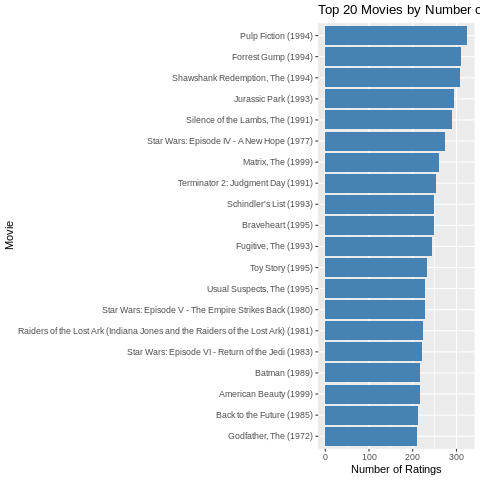

In [ ]:
%%R
library(ggplot2)

movie_counts <- colCounts(rating_matrix)
df <- data.frame(movie = names(movie_counts), ratings = movie_counts)

ggplot(df %>% top_n(20, wt = ratings), aes(x = reorder(movie, ratings), y = ratings)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(title = "Top 20 Movies by Number of Ratings", x = "Movie", y = "Number of Ratings")